### Multivariate Output Stacked LSTM using Iterative Prediction

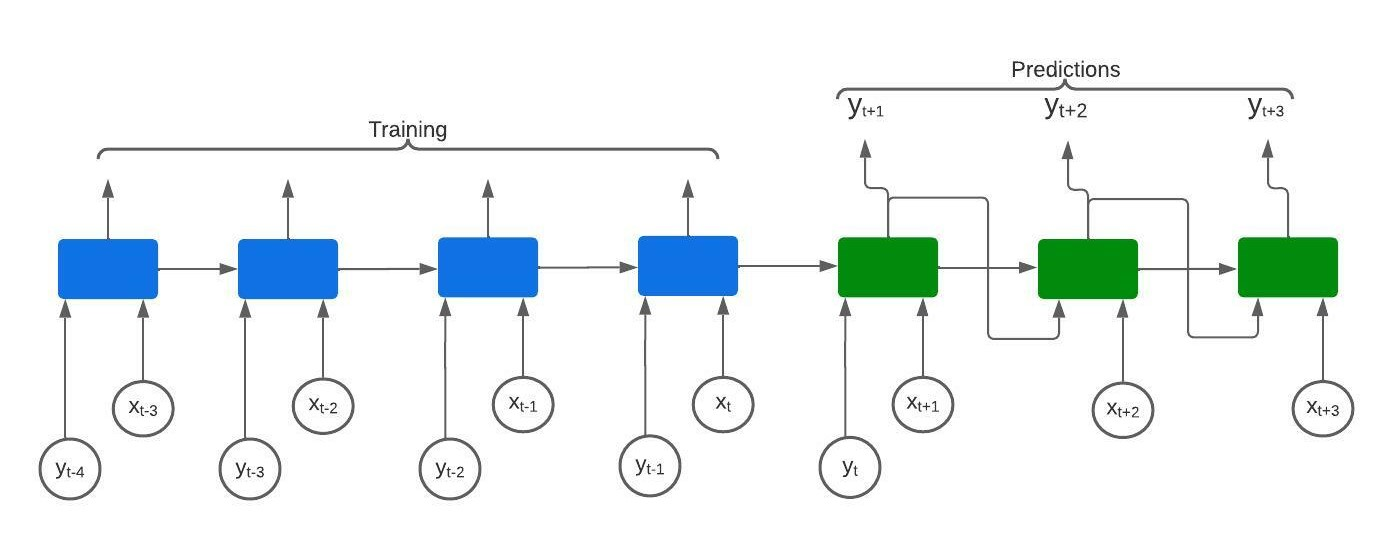

## Prediction using a standard dataset (benchmark) to investigate the usefulness of the data

Summarizing data with Pandas
- info()
- describe()
- value_counts()
- nunique()
- sum()
- count()
- min(), max(), mean(), and median()
- agg()
- groupby()

In [33]:
### I need a different dataset
from pandas import read_csv
# sim_data = read_csv("waterTank.csv")
sim_data = read_csv("simulated_waterTank.csv")
sim_data.describe()
print('The size of the data', sim_data.size)
# sim_data["wt3_valve"].value_counts()

The size of the data 6000


In [34]:
sim_data.head(10)

,Time,WaterTank1InFlow,Tank1WaterLevel,Tank2WaterLevel,Tank2OutFlow,WaterTank2State,Tank2Puddle,Tank3OutFlow,Tank2.level,controllerwt3_valve
0,0.00,0,1.000000e-06,0.000000e+00,0.0,0.0,0.022568,0.0,0.0,False
1,0.05,0,6.890000e-07,3.110000e-07,0.0,0.0,0.022568,0.0,0.0,False
2,0.10,1,3.333928e-03,4.050000e-07,0.0,0.0,0.022568,0.0,0.0,False
3,0.15,1,5.448433e-02,8.850002e-03,0.0,0.0,0.022568,0.0,0.0,False
4,0.20,0,7.717051e-02,2.949715e-02,0.0,0.0,0.022568,0.0,0.0,False
5,0.25,0,6.660111e-02,4.006656e-02,0.0,0.0,0.022568,0.0,0.0,False
6,0.30,0,6.073531e-02,4.593236e-02,0.0,0.0,0.022568,0.0,0.0,False
7,0.35,1,9.583037e-02,5.417063e-02,0.0,0.0,0.022568,0.0,0.0,False
8,0.40,1,1.233515e-01,6.664952e-02,0.0,0.0,0.022568,0.0,0.0,False
9,0.45,0,1.194144e-01,8.725326e-02,0.0,0.0,0.022568,0.0,0.0,False


In [35]:
sim_data = sim_data.values
# sim_data.head()
sim_data[:,1].size

600

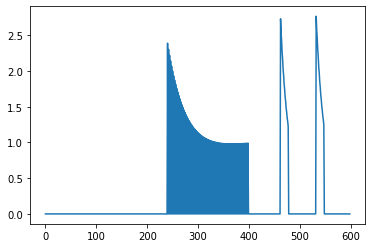

In [36]:
import matplotlib.pyplot as plt
# sim_data = sim_data.values
plt.plot(sim_data[1:650,7])
plt.show()

### Prediction with the Water Tank Simulated dataset (Direct Strategy)

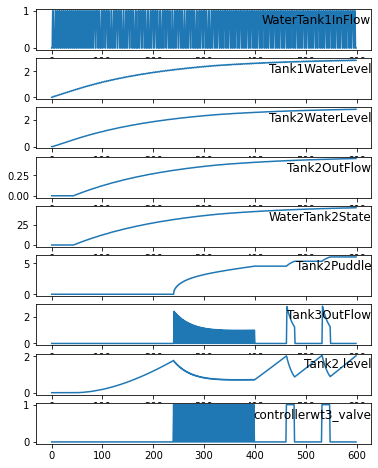

In [42]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('simulated_waterTank.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
# plot each column
pyplot.figure().set_figheight(8)
# pyplot.figure().set_figwidth(10)
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

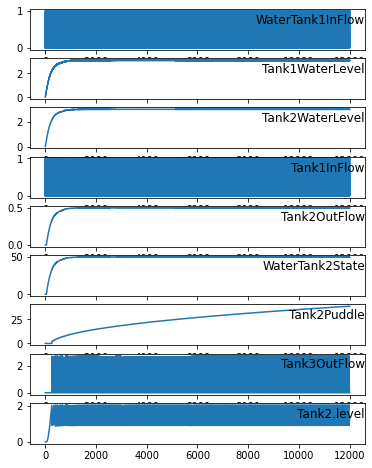

In [43]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('outputs.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
# plot each column
pyplot.figure().set_figheight(8)
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [48]:
# from pandas import read_csv
# from matplotlib import pyplot
# # load dataset
# dataset = read_csv('trig.csv', header=0, index_col=0)
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

### Direct Method for Water Tank

In [3]:
# multivariate output stacked lstm example
import pandas as pd
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
data = read_csv('waterTank.csv', header=0, index_col=0)
# data = read_csv('outputs.csv', header=0, index_col=0)
# data = read_csv('trig.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 1000
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps_in, n_steps_out = 50, 100
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=50, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

The shape of the raw_data before scaling is (11940, 8)
Epoch 1/50
27/27 - 4s - loss: 0.1824 - 4s/epoch - 147ms/step
Epoch 2/50
27/27 - 1s - loss: 0.1636 - 1s/epoch - 52ms/step
Epoch 3/50
27/27 - 1s - loss: 0.1629 - 1s/epoch - 53ms/step
Epoch 4/50
27/27 - 1s - loss: 0.1625 - 1s/epoch - 53ms/step
Epoch 5/50
27/27 - 1s - loss: 0.1620 - 1s/epoch - 55ms/step
Epoch 6/50
27/27 - 1s - loss: 0.1616 - 1s/epoch - 53ms/step
Epoch 7/50
27/27 - 1s - loss: 0.1613 - 1s/epoch - 53ms/step
Epoch 8/50
27/27 - 1s - loss: 0.1611 - 1s/epoch - 53ms/step
Epoch 9/50
27/27 - 1s - loss: 0.1609 - 1s/epoch - 53ms/step
Epoch 10/50
27/27 - 1s - loss: 0.1608 - 1s/epoch - 55ms/step
Epoch 11/50
27/27 - 1s - loss: 0.1607 - 1s/epoch - 55ms/step
Epoch 12/50
27/27 - 2s - loss: 0.1607 - 2s/epoch - 57ms/step
Epoch 13/50
27/27 - 2s - loss: 0.1607 - 2s/epoch - 57ms/step
Epoch 14/50
27/27 - 2s - loss: 0.1609 - 2s/epoch - 56ms/step
Epoch 15/50
27/27 - 2s - loss: 0.1606 - 2s/epoch - 57ms/step
Epoch 16/50
27/27 - 1s - loss: 0.1606 

ValueError: cannot reshape array of size 100 into shape (100,8)

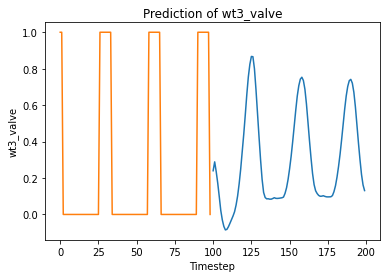

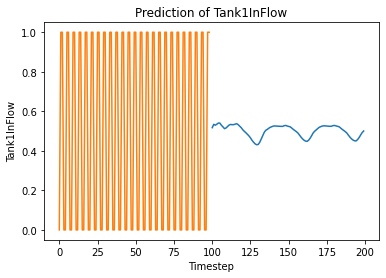

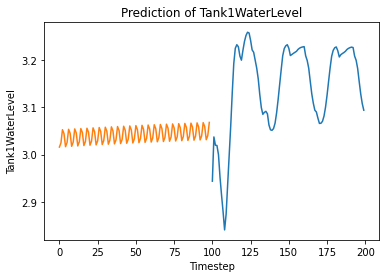

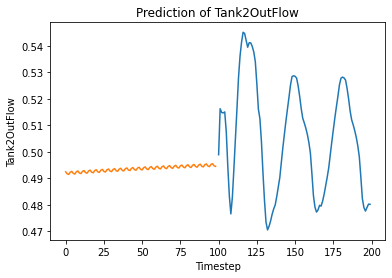

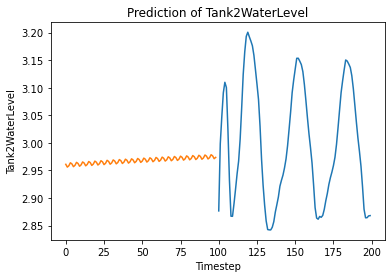

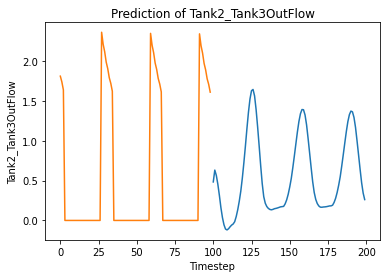

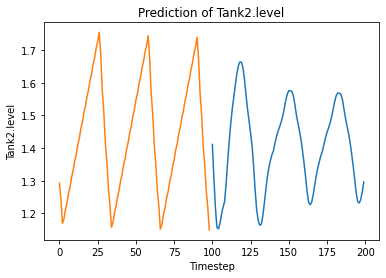

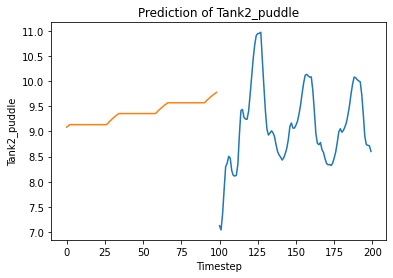

In [2]:
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank2OutFlow","Tank2WaterLevel", "Tank2_Tank3OutFlow", "Tank2.level", "Tank2_puddle"]
# attr = ["sine"]
for i in range(len(attr)):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[951:1050,i]
    pred = inv_yhat.T
    pred_df = pd.DataFrame(inv_yhat)
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()

In [18]:
# attr = ["sine", "cosine", "sin(2t)", "func"]
# # attr = ["sine"]
# for i in range(len(attr)):
#     title = "Prediction of "+str(attr[i])
#     actual = raw_data[951:1050,i]
#     pred = inv_yhat.T
#     pred_df = pd.DataFrame(inv_yhat)
#     index = pd.Index(list(range(100,200)))
#     pred_df = pred_df.set_index(index)
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel(attr[i])
# #     plt.plot(pred[i], label="predicted")
# #     plt.plot(actual, label="actual")
#     plt.plot(pred_df[i])
#     plt.plot(actual)
#     plt.show()

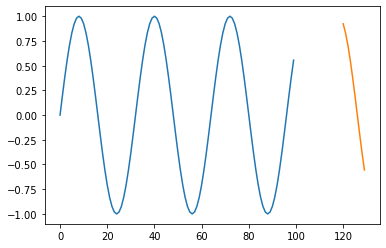

In [149]:
import pandas as pd
data = pd.read_csv("mergeTest.csv")
myData = data[0:100]
otherData = data[10:20]
ind = pd.Index(list(range(120,130)))
# otherData = otherData.set_index([1,2,3,4,5,6,7,8,9])
otherData = otherData.set_index(ind)
otherData
# totalData = pd.merge(myData[0:50], otherData[0:90], how = "left", left_index = True, right_index = True)
# plt.plot(totalData)
plt.plot(myData)
plt.plot(otherData)



C:\Users\user\AppData\Local\Temp\ipykernel_22236\1433085207.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  datelist = pd.date_range(pd.datetime(2018, 1, 1), periods=104)


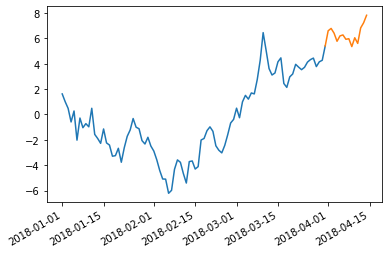

In [105]:
import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

datelist = pd.date_range(pd.datetime(2018, 1, 1), periods=104)
df = pd.DataFrame(np.cumsum(np.random.randn(104)),columns=['price'],index=datelist)
plt.plot(df[:90].index, df[:90].values)
plt.plot(df[89:].index, df[89:].values)
plt.gcf().autofmt_xdate()
plt.show()

In [19]:
# import pandas as pd
# # df_output = pd.merge(raw_data, pred, how = "left", left_index = True, right_index = True)
# attr = ["sine", "cosine", "sin(2t)", "func"]
# for i in range(len(attr)):
#     title = "Prediction of "+str(attr[i])
#     actual = raw_data[951:1050,i]
#     pred = inv_yhat.T
# #     pred = inv_yhat
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel(attr[i])
#     actual['pred'] = pred[i];
#     df_output = pd.merge(actual,actual[["pred"]], how = "left", left_index = True, right_index = True)
# #     plt.plot(output)
# #     plt.plot(pred[i], label="predicted")
# #     plt.plot(actual, label="actual")
#     plt.plot(df_output)
#     plt.legend()
#     plt.show()

### Direct Method for Air Pollution

In [22]:
# multivariate output stacked lstm example
import pandas as pd
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
data = read_csv('pollution2.csv', header=0, index_col=0)
# data = read_csv('outputs.csv', header=0, index_col=0)
# data = read_csv('trig.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 20000
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps_in, n_steps_out = 500, 500
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=30, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

The shape of the raw_data before scaling is (43800, 5)
Epoch 1/30
594/594 - 248s - loss: 0.0130 - 248s/epoch - 418ms/step
Epoch 2/30
594/594 - 247s - loss: 0.0104 - 247s/epoch - 415ms/step
Epoch 3/30
594/594 - 248s - loss: 0.0107 - 248s/epoch - 417ms/step
Epoch 4/30
594/594 - 278s - loss: 0.0110 - 278s/epoch - 469ms/step
Epoch 5/30
594/594 - 282s - loss: 0.0096 - 282s/epoch - 475ms/step
Epoch 6/30
594/594 - 267s - loss: 0.0094 - 267s/epoch - 450ms/step
Epoch 7/30
594/594 - 1703s - loss: nan - 1703s/epoch - 3s/step
Epoch 8/30
594/594 - 268s - loss: nan - 268s/epoch - 450ms/step
Epoch 9/30
594/594 - 246s - loss: nan - 246s/epoch - 415ms/step
Epoch 10/30
594/594 - 248s - loss: nan - 248s/epoch - 418ms/step
Epoch 11/30
594/594 - 247s - loss: nan - 247s/epoch - 416ms/step
Epoch 12/30
594/594 - 253s - loss: nan - 253s/epoch - 425ms/step
Epoch 13/30
594/594 - 263s - loss: nan - 263s/epoch - 442ms/step
Epoch 14/30
594/594 - 246s - loss: nan - 246s/epoch - 415ms/step
Epoch 15/30


KeyboardInterrupt: 

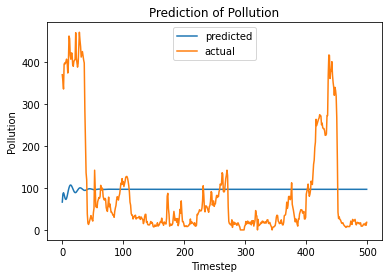

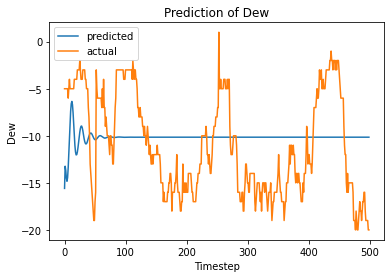

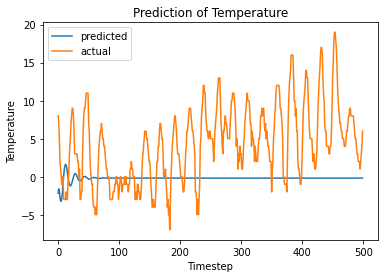

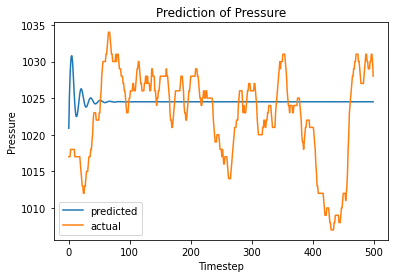

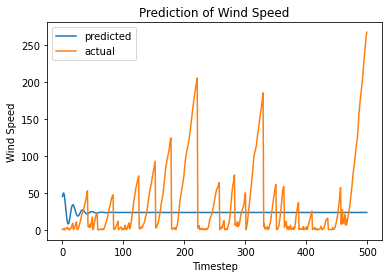

In [18]:
# attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank2OutFlow", "Tank2WaterLevel", "Tank2_Tank3OutFlow", "Tank2.level", "Tank2_puddle"]
attr = ["Pollution", "Dew", "Temperature", "Pressure", "Wind Speed"]
for i in range(len(attr)):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[20000:20500,i]
    pred = inv_yhat.T
#     pred = inv_yhat
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(pred[i], label="predicted")
    plt.plot(actual, label="actual")
    plt.legend()
    plt.show()

In [14]:
len(inv_yhat.T)

5

The shape of the raw_data before scaling is (600, 9)
Epoch 1/30
14/14 - 3s - loss: 0.2460 - 3s/epoch - 201ms/step
Epoch 2/30
14/14 - 1s - loss: 0.0968 - 618ms/epoch - 44ms/step
Epoch 3/30
14/14 - 1s - loss: 0.0790 - 619ms/epoch - 44ms/step
Epoch 4/30
14/14 - 1s - loss: 0.0726 - 616ms/epoch - 44ms/step
Epoch 5/30
14/14 - 1s - loss: 0.0676 - 615ms/epoch - 44ms/step
Epoch 6/30
14/14 - 1s - loss: 0.0639 - 621ms/epoch - 44ms/step
Epoch 7/30
14/14 - 1s - loss: 0.0600 - 630ms/epoch - 45ms/step
Epoch 8/30
14/14 - 1s - loss: 0.0586 - 622ms/epoch - 44ms/step
Epoch 9/30
14/14 - 1s - loss: 0.0554 - 626ms/epoch - 45ms/step
Epoch 10/30
14/14 - 1s - loss: 0.0534 - 617ms/epoch - 44ms/step
Epoch 11/30
14/14 - 1s - loss: 0.0519 - 627ms/epoch - 45ms/step
Epoch 12/30
14/14 - 1s - loss: 0.0530 - 632ms/epoch - 45ms/step
Epoch 13/30
14/14 - 1s - loss: 0.0605 - 638ms/epoch - 46ms/step
Epoch 14/30
14/14 - 1s - loss: 0.0545 - 642ms/epoch - 46ms/step
Epoch 15/30
14/14 - 1s - loss: 0.0534 - 642ms/epoch - 46ms/ste

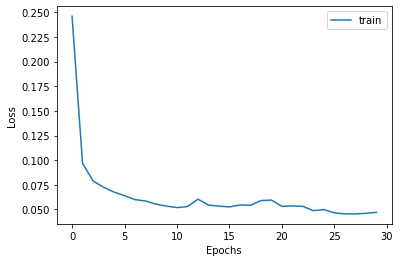

In [20]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
# data = read_csv('waterTank.csv', header=0, index_col=0)
data = read_csv('outputs.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

# n_train = 10000
n_train = 500
#dataset = raw_data[0:n_train,:]
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps_in, n_steps_out = 50, 30
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=30, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
train = pd.DataFrame(raw_data[450:500, 1], columns = ["y_pred"])
pred = pd.DataFrame()

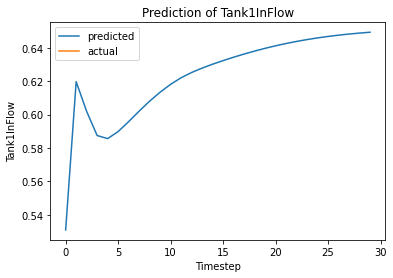

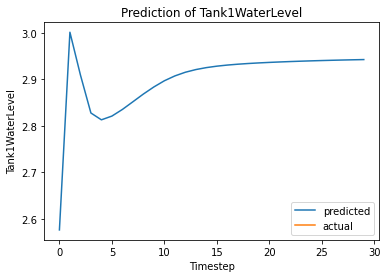

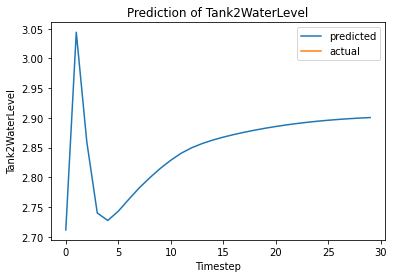

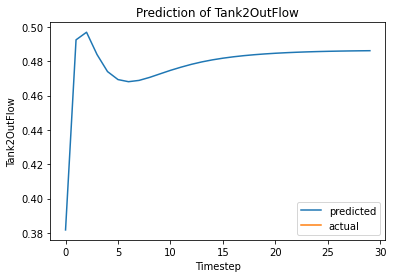

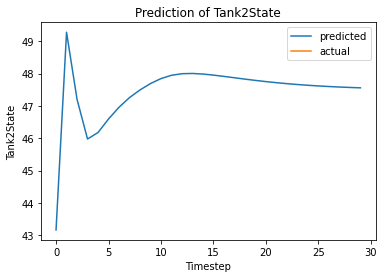

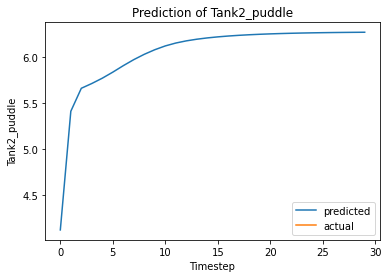

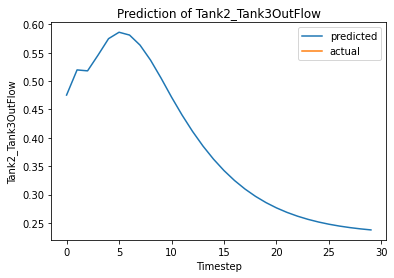

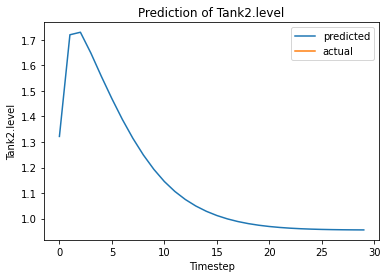

In [21]:
# attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank2OutFlow", "Tank2WaterLevel", "Tank2_Tank3OutFlow", "Tank2.level", "Tank2_puddle"]
attr = ["Tank1InFlow", "Tank1WaterLevel", "Tank2WaterLevel", "Tank2OutFlow", "Tank2State", "Tank2_puddle", "Tank2_Tank3OutFlow", "Tank2.level", "wt3_valve"]
for i in range(8):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[10050:10080,i]
    pred = inv_yhat.T
#     pred = inv_yhat
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(pred[i], label="predicted")
    plt.plot(actual, label="actual")
    plt.legend()
    plt.show()

In [82]:
# save the model
model.save("enc_dec_lstm_model.h5")
print("Model saved to disk");

Model saved to disk


### Fault Injection

In [90]:
my_dat = read_csv("waterTank.csv", header=0)
my_data = my_dat.iloc[1:50,1:]
my_data.head()

,wt3_valve,Tank1InFlow,Tank1WaterLevel,Tank2OutFlow,Tank2WaterLevel,Tank2_Tank3OutFlow,Tank2.level,Tank2_puddle
1,0,0,6.890000e-07,0.0,3.110000e-07,0.0,0.0,0.022568
2,0,1,3.333928e-03,0.0,4.050000e-07,0.0,0.0,0.022568
3,0,1,5.448433e-02,0.0,8.850002e-03,0.0,0.0,0.022568
4,0,0,7.717051e-02,0.0,2.949715e-02,0.0,0.0,0.022568
5,0,0,6.660111e-02,0.0,4.006656e-02,0.0,0.0,0.022568


In [93]:
from pandas import read_csv
from random import randint
# from random import random
import random
import math


def inject_Fault_Univariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for i in range(len(data)):
        p = random.random()
        if p > 0.5:
            data["column"].iloc[i] += random.choice(fault_units)
            
    return data

def inject_Fault_Multivariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for col in data.columns:
        
        for i in range(len(data)):
            p = random.random()
            if p > 0.5:
                data[col].iloc[i] += random.choice(fault_units)

    return data

def bit_flip(data, col):
    if (len(data[col].unique())):
        for i in data[col]:
            data[col][i] = random.randint(0,1)
    return data

def insert_outlier(data, col):
#     // This inserts at the beginning of the data
    maxi = data.describe()[col]["max"]
    mini = data.describe()[col]["min"]
    outlier = (maxi - mini)*50
    n = math.floor(len(data)*0.2)
    for i in range(len(data[col][0:n])):
        data[col].iloc[i] += outlier    
    return data

def stuck_at(data, val, col, loc="beg"):
    # This is either stuck_at zero or at 1
    if(loc == "beg"):
        n = math.floor(len(data[col])*0.3)
        for i in range(n):
            data[col][i] = val
    return data



my_data = read_csv("waterTank.csv", header=0)
my_data = my_data.iloc[1:50,:]

# myNewdata = inject_Fault_Univariate(my_data)
myNewdata = inject_Fault_Multivariate(my_data)
myNewdata.to_csv("Randomized_data.csv")

flipped_data = bit_flip(my_data, "Tank1InFlow")
flipped_data.to_csv("flipped_data.csv")

outliered = insert_outlier(my_data, "Tank2WaterLevel")
outliered.to_csv("outlier_data.csv")

stuck_data = stuck_at(my_data, 1, "Tank1InFlow", loc="beg")
stuck_data.to_csv("stuck_at_one.csv")

print("Files saved successfully")

C:\Users\hayatu4islam\AppData\Local\Temp\ipykernel_6692\1794624121.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].iloc[i] += random.choice(fault_units)


Files saved successfully


In [99]:
randomized = read_csv("Randomized_data.csv", header=0).ilo
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(randomized)
x_input = scaled_data.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

yhat = yhat.reshape(n_steps_out, n_features)
# print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
# print(inv_yhat)

attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank2OutFlow", "Tank2WaterLevel", "Tank2_Tank3OutFlow", "Tank2.level", "Tank2_puddle"]
for i in range(8):
    title = "Prediction of "+str(attr[i])
    actual = randomized[10051:10080,i]
    pred = inv_yhat.T
#     pred = inv_yhat
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(pred[i], label="predicted")
    plt.plot(actual, label="actual")
    plt.legend()
    plt.show()

ValueError: cannot reshape array of size 490 into shape (1,50,8)

In [100]:
randomized = read_csv("Randomized_data.csv", header=0)
randomized.shape

(49, 10)

In [3]:
from pandas import read_csv
my_dataset = read_csv("waterTank.csv", header=0)
my_dataset.describe()

,Unnamed: 0,wt3_valve,Tank1InFlow,Tank1WaterLevel,Tank2OutFlow,Tank2WaterLevel,Tank2_Tank3OutFlow,Tank2.level,Tank2_puddle
count,11940.000000,11940.000000,11940.000000,1.194000e+04,11940.000000,11940.000000,11940.000000,11940.000000,11940.000000
mean,298.475000,0.243635,0.501089,3.020027e+00,0.489348,2.945851,0.476949,1.427974,25.011964
std,172.346272,0.429293,0.500020,2.838824e-01,0.054100,0.279319,0.848382,0.229518,9.768620
min,0.000000,0.000000,0.000000,6.890000e-07,0.000000,0.000000,0.000000,0.000000,0.022568
25%,149.237500,0.000000,0.000000,3.057439e+00,0.499199,2.995754,0.000000,1.279368,18.432995
50%,298.475000,0.000000,1.000000,3.070966e+00,0.499715,2.998294,0.000000,1.429086,26.821231
75%,447.712500,0.000000,1.000000,3.085092e+00,0.500677,3.003658,0.000000,1.583285,33.189908
max,596.950000,1.000000,1.000000,3.102069e+00,0.501029,3.005633,2.391659,1.776479,38.476865
